In [11]:
import os
import numpy as np
import pandas as pd

# Define folder paths relative to this notebook
raw_dir = '../data/raw'
processed_dir = '../data/processed'

# Create folders if they don't exist
os.makedirs(raw_dir, exist_ok=True)
os.makedirs(processed_dir, exist_ok=True)

# Generate business day dates
dates = pd.date_range(start="2022-01-03", end="2022-06-10", freq="B")

# Fixed random seed for reproducibility
np.random.seed(17)

# Column 1: daily_return ~ N(0, 0.01)
returns = np.random.normal(0, 0.01, size=len(dates))
mask_pre_may = dates < "2022-05-01"
returns[mask_pre_may] -= 0.0015

# Inject "shock" values
shock_values = {
    "2022-05-02": 0.1748425237194541,
    "2022-05-03": -0.16825801732486943,
    "2022-05-06": -0.19667220757153227,
    "2022-05-09": 0.21240223590614747,
    "2022-05-12": -0.178729287231294
}
for d, v in shock_values.items():
    idx = np.where(dates == pd.to_datetime(d))[0][0]
    returns[idx] = v

# Column 2: daily_return_2, correlated with daily_return + small noise
daily_return_2 = returns * 0.6 + np.random.normal(0, 0.005, size=len(dates))

# Create DataFrame with two numeric columns
df = pd.DataFrame({
    "date": dates,
    "daily_return": returns,
    "daily_return_2": daily_return_2
})

# Save to CSV in raw data folder
csv_path = os.path.join(raw_dir, 'outliers_homework.csv')
if not os.path.exists(csv_path):
    df.to_csv(csv_path, index=False)
    print(f'Synthetic dataset with two columns created and saved to {csv_path}')
else:
    print(f'File already exists at {csv_path}. Skipping CSV creation to avoid overwrite.')

Synthetic dataset with two columns created and saved to ../data/raw\outliers_homework.csv


In [13]:
def detect_outliers_iqr(series):
    """
    Detects outliers in a pandas Series using the IQR method.

    Args:
        series (pd.Series): The data series to check for outliers.

    Returns:
        pd.Series: A boolean Series where True indicates an outlier.
    """
    # Calculate the first (Q1) and third (Q3) quartiles
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    
    # Calculate the Interquartile Range (IQR)
    iqr = q3 - q1
    
    # Define the outlier boundaries
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    # Return a boolean series indicating outliers
    return (series < lower_bound) | (series > upper_bound)

def detect_outliers_zscore(series, threshold=3.0):
    """
    Detects outliers in a pandas Series using the Z-score method.

    Args:
        series (pd.Series): The data series to check for outliers.
        threshold (float): The Z-score threshold to use. Defaults to 3.0.

    Returns:
        pd.Series: A boolean Series where True indicates an outlier.
    """
    mean = series.mean()
    std_dev = series.std()
    z_scores = (series - mean) / std_dev
    return np.abs(z_scores) > threshold

Outlier counts:
is_outlier
False    106
True       9
Name: count, dtype: int64


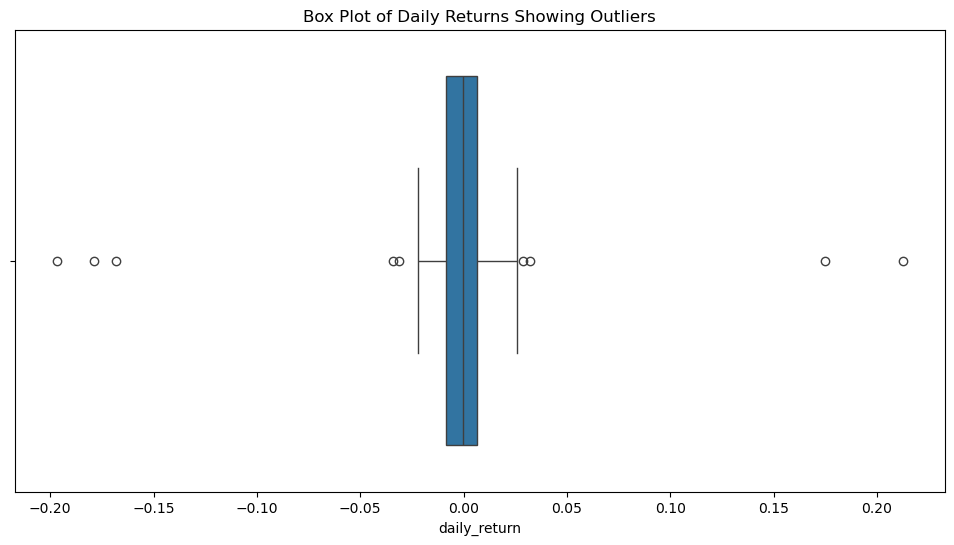

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Choose a method (e.g., IQR) and apply it to the 'daily_return' column
outlier_flags = detect_outliers_iqr(df['daily_return'])

# Add the results as a new column in your DataFrame
df['is_outlier'] = outlier_flags

# See how many outliers you found
print("Outlier counts:")
print(df['is_outlier'].value_counts())

# Visualize the data to see the outliers
plt.figure(figsize=(12, 6))
sns.boxplot(x=df['daily_return'])
plt.title('Box Plot of Daily Returns Showing Outliers')
plt.show()

In [17]:
# Create a new DataFrame with the outliers removed
df_no_outliers = df[df['is_outlier'] == False]

print("--- Summary Statistics WITH Outliers ---")
print(df['daily_return'].describe())

print("\n--- Summary Statistics WITHOUT Outliers ---")
print(df_no_outliers['daily_return'].describe())

--- Summary Statistics WITH Outliers ---
count    115.000000
mean      -0.001434
std        0.040579
min       -0.196672
25%       -0.008525
50%       -0.000187
75%        0.006368
max        0.212402
Name: daily_return, dtype: float64

--- Summary Statistics WITHOUT Outliers ---
count    106.000000
mean      -0.000039
std        0.009443
min       -0.021860
25%       -0.007213
50%       -0.000100
75%        0.006018
max        0.025708
Name: daily_return, dtype: float64


        Metric  With Outliers  Without Outliers
0    R-squared       0.961859          0.573566
1          MAE       0.003951          0.003851
2  Coefficient       0.605869          0.589679


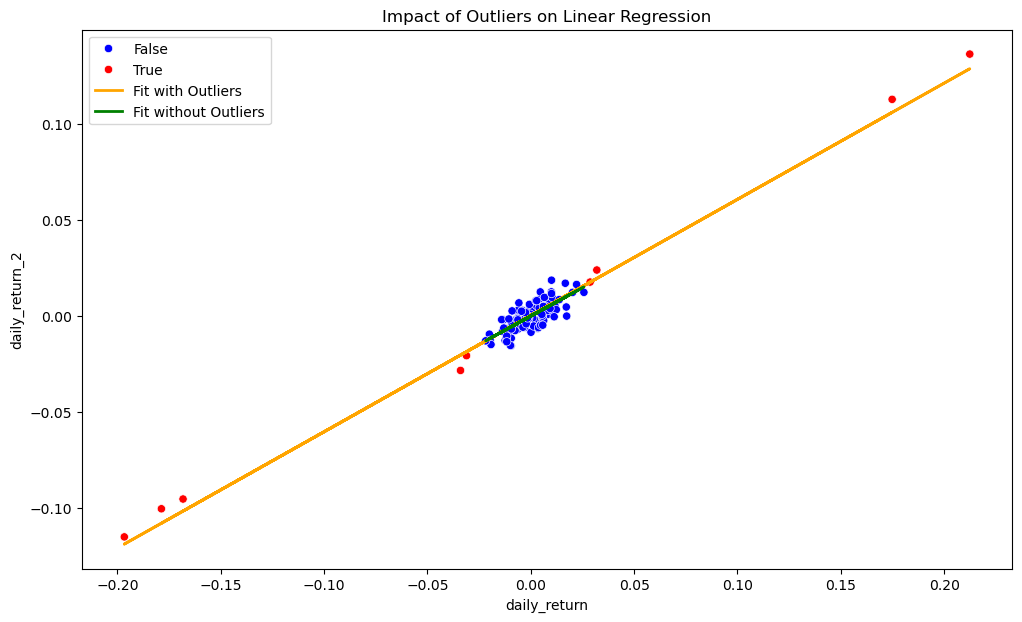

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error

# --- 1. Model with Outliers ---
X_with = df[['daily_return']]
y_with = df['daily_return_2']

model_with = LinearRegression()
model_with.fit(X_with, y_with)
preds_with = model_with.predict(X_with)

# --- 2. Model without Outliers ---
X_without = df_no_outliers[['daily_return']]
y_without = df_no_outliers['daily_return_2']

model_without = LinearRegression()
model_without.fit(X_without, y_without)
preds_without = model_without.predict(X_without)

# --- 3. Compare Results in a Table ---
results = {
    'Metric': ['R-squared', 'MAE', 'Coefficient'],
    'With Outliers': [
        r2_score(y_with, preds_with),
        mean_absolute_error(y_with, preds_with),
        model_with.coef_[0]
    ],
    'Without Outliers': [
        r2_score(y_without, preds_without),
        mean_absolute_error(y_without, preds_without),
        model_without.coef_[0]
    ]
}
results_df = pd.DataFrame(results)
print(results_df)

# --- 4. Visualize the difference ---
plt.figure(figsize=(12, 7))
sns.scatterplot(x='daily_return', y='daily_return_2', data=df, hue='is_outlier', palette=['blue', 'red'])
plt.plot(X_with, preds_with, color='orange', linewidth=2, label='Fit with Outliers')
plt.plot(X_without, preds_without, color='green', linewidth=2, label='Fit without Outliers')
plt.title('Impact of Outliers on Linear Regression')
plt.legend()
plt.show()

## Reflection: Outlier Analysis
Method Chosen: 
I used the IQR method because it's not affected by the extreme outliers themselves, making it a more reliable way to identify them.

Core Assumption: 
I assumed the outliers were data errors or flukes, not real, meaningful events.

Observed Impact: 
Removing the outliers significantly changed the results-The mean and standard deviation of daily_return decreased.

The linear model fit the data better: R-squared increased and MAE decreased.

The regression line on the plot shifted to better fit the main cluster of data.

Risks: 
The biggest risk is if my assumption was wrong and the outliers were real market shocks. If so, removing them creates a misleading model that underestimates real-world risk and would fail during a critical event.







